# TensorFlow Model and Interpretation

In this notebook, we document the processes involved in creating the TensorFlow model. <br>
We also analyze our results using interpretation tools, such as PDP plots and SHAP. <br>
The final model, which is exportable to a separate notebook, is formed to conclude.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
from sklearn.inspection import partial_dependence, plot_partial_dependence
from sklearn.preprocessing import StandardScaler
from sklearn.utils import validation
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import shap

In [2]:
# Set random seeds
seed_value= 1234
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

## Data preprocessing

In [5]:
# Data for 3 seasons
df = pd.read_csv("stats1.csv")
df.astype({"xG": "float32", "possession": "float32", "passing_accuracy": "float32"})

,team,goals,xG,possession,passing_accuracy,shots_on_target,shots,saves,fouls,corners,crosses,touches,tackles,interceptions,aerials_won,clearances,offsides,goal_kicks,throw_ins,long_balls
0,Liverpool,4,1.7,0.57,0.79,7,15,5,10,11,15,633,24,11,14,5,0,6,18,57
1,Manchester Utd,2,1.6,0.46,0.79,5,7,3,18,2,8,625,19,14,3,24,3,4,13,57
2,Arsenal,3,2.4,0.59,0.83,4,20,7,13,9,17,604,18,7,6,17,2,8,16,48
3,Everton,0,0.9,0.70,0.81,3,16,0,10,12,24,719,14,5,18,29,1,5,37,72
4,Burnley,2,1.5,0.42,0.74,6,13,2,12,7,17,520,19,10,18,15,1,7,24,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2275,Everton,0,1.0,0.65,0.79,2,10,2,13,2,15,703,17,8,18,24,0,5,39,65
2276,Southampton,0,0.8,0.54,0.69,3,12,1,14,7,9,557,11,6,25,55,1,11,34,100
2277,Sheffield Utd,1,1.0,0.47,0.77,3,8,2,21,4,12,593,17,15,18,18,0,7,28,80
2278,Brighton,3,0.7,0.50,0.80,3,4,3,11,2,9,594,17,13,18,38,3,8,19,79


In [6]:
target = df[["goals"]]
features = df[["possession", "passing_accuracy", "shots_on_target", "saves", "tackles", "fouls", 
               "interceptions", "goal_kicks", "corners", "crosses"]]

In [7]:
# Split data into relevant datasets
train_features, test_features, train_targets, test_targets = train_test_split(features, target, test_size = 0.2)
train_features, val_features, train_targets, val_targets = train_test_split(train_features, train_targets, test_size = 0.2)

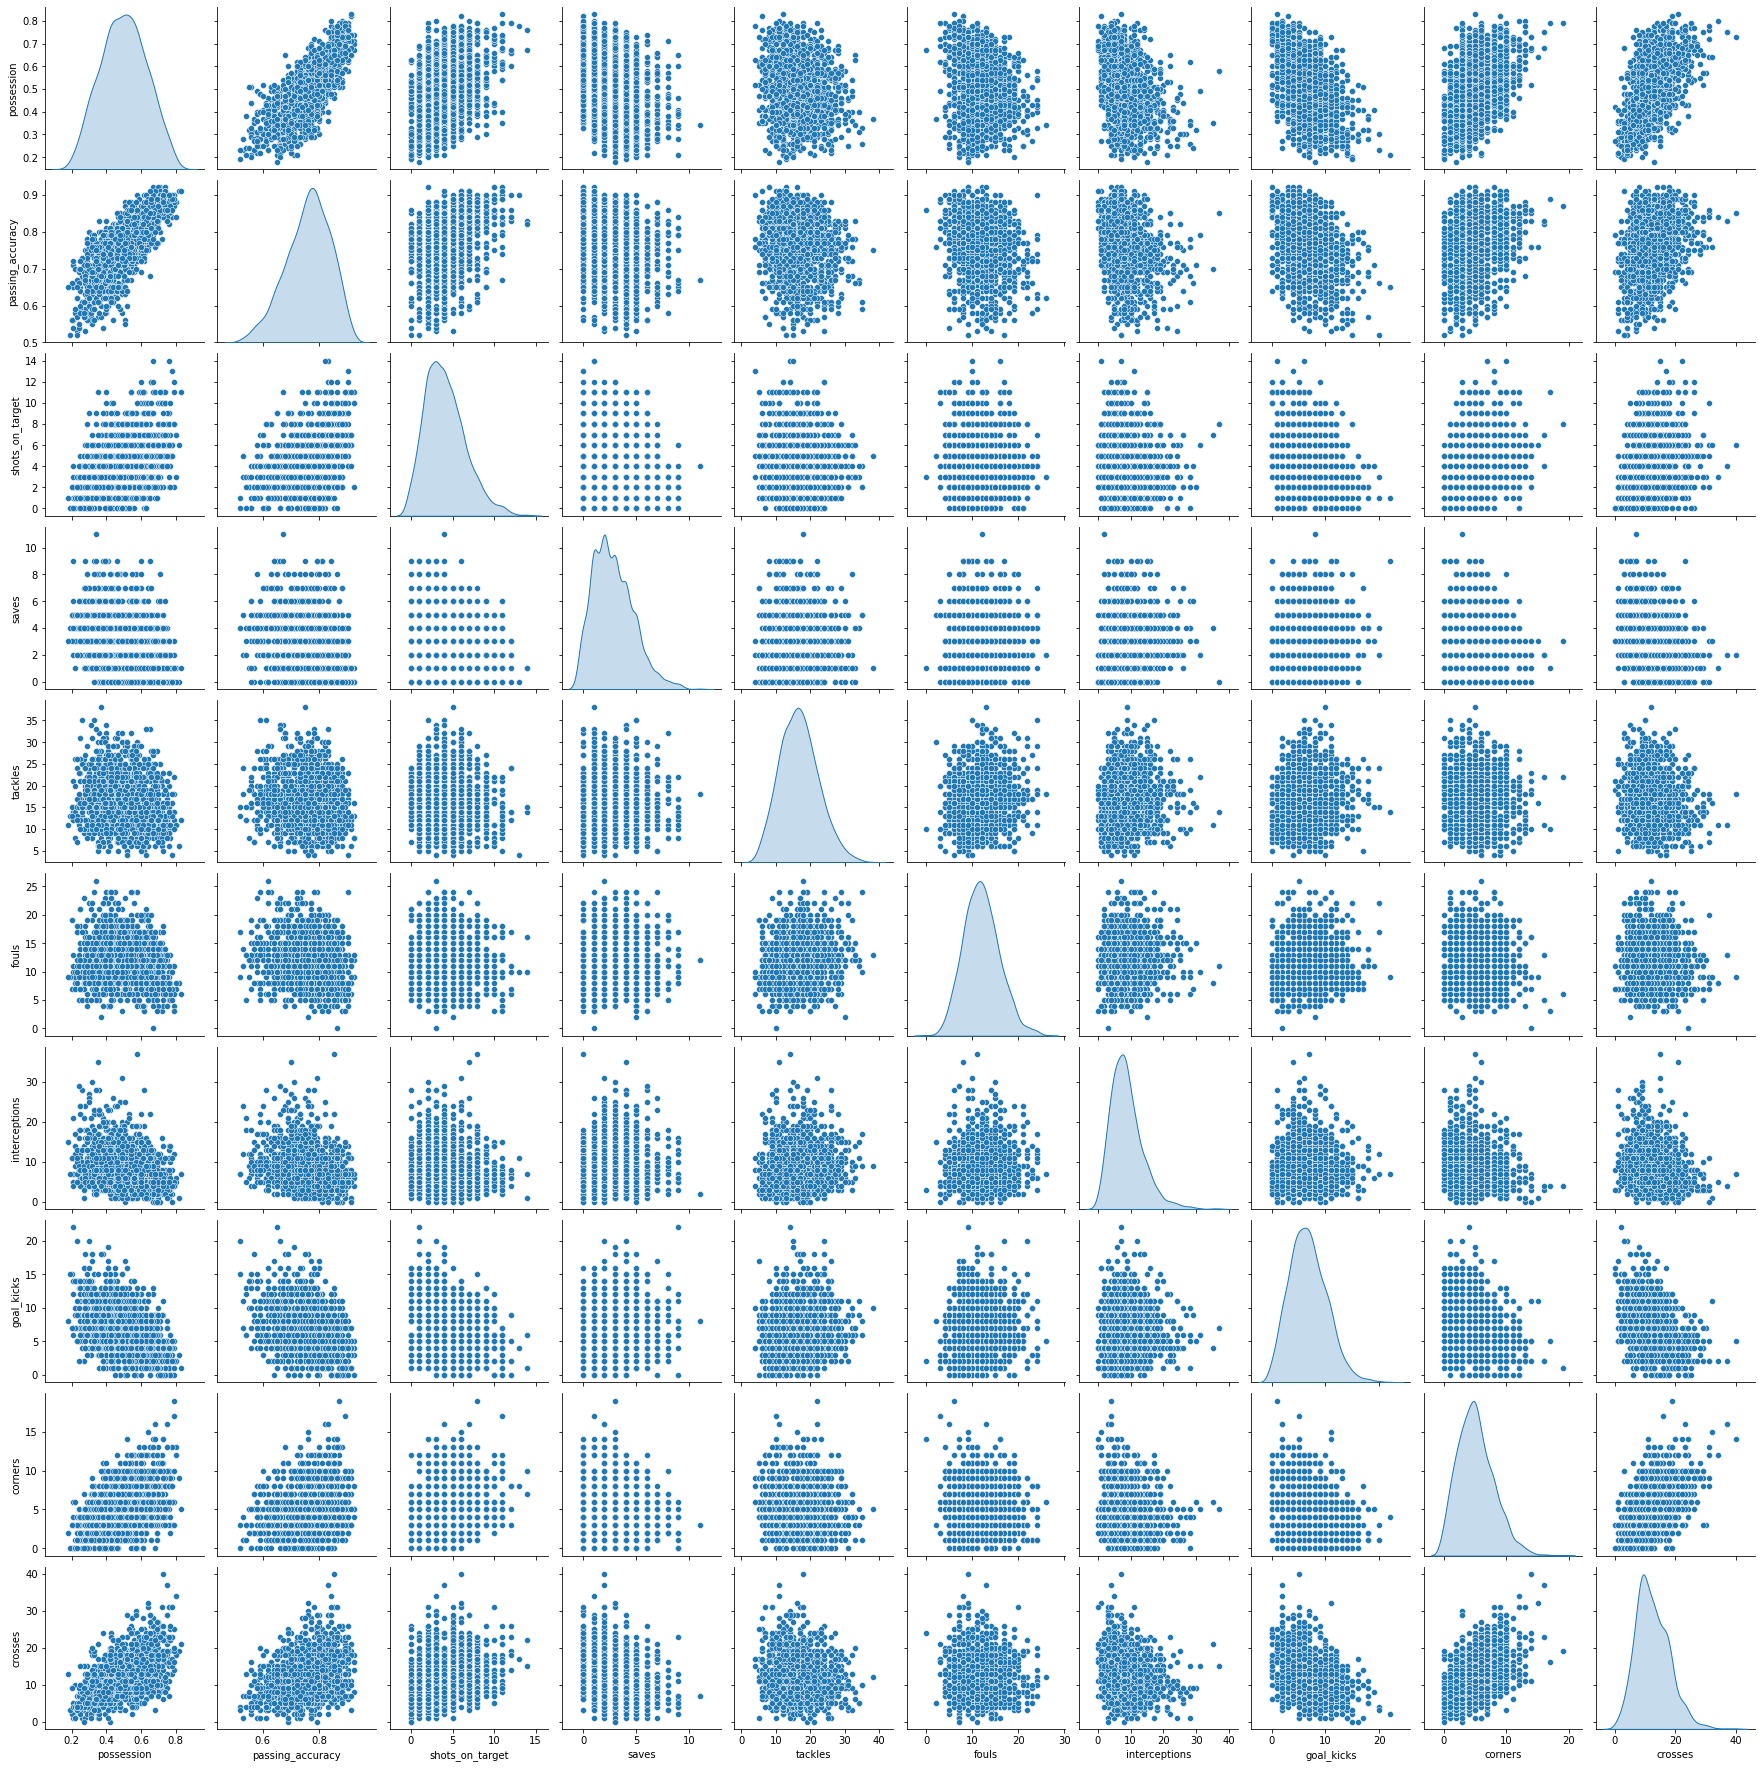

In [8]:
# Visualize the relationships of the explanatory variables
sns.pairplot(train_features[["possession", "passing_accuracy", "shots_on_target", "saves", "tackles", "fouls", 
                            "interceptions", "goal_kicks", "corners", "crosses"]], diag_kind='kde')

In [9]:
# Normalize the split datasets
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

## Model creation and evaluation

In [10]:
goalspred = models.Sequential([
    keras.Input(shape = (10, )), 
    layers.Dense(10, activation = "elu"),
    layers.Dense(60, activation = "selu"),
    layers.Dense(30, activation = "selu"), 
    layers.Dense(12, activation = "selu"), 
    layers.Dense(1)
])

In [11]:
print(goalspred.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                110       
_________________________________________________________________
dense_1 (Dense)              (None, 60)                660       
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_3 (Dense)              (None, 12)                372       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 13        
Total params: 2,985
Trainable params: 2,985
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
# To have at least steps_per_epoch * epochs batches
batch = 50
steps = len(train_features)//batch
validation_steps = len(val_features)//batch

goalspred.compile(optimizer = "adam",
              loss = "mse")

goalspred.fit(train_features, 
                    train_targets, 
                    epochs = 200, 
                    batch_size = batch, 
                    verbose = 0, 
                    steps_per_epoch = steps, 
                    validation_data = (val_features, val_targets), 
                    validation_steps = validation_steps)

goalspred.evaluate(test_features, test_targets, verbose = 0)

1.1521681547164917

## Model interpretation

In [13]:
# sklearn has a bug when utilizing non-sklearn models
# This is incorporated to fix it.
goalspred._estimator_type = "regressor"
goalspred.dummy_ = None   # works around the underscore issue
validation.check_is_fitted(estimator=goalspred)

In [14]:
featurelabels = ["possession", "passing_accuracy", "shots_on_target", "saves", "tackles", "fouls",
           "interceptions", "goal_kicks", "corners", "crosses"]

### Partial dependence plots and individual conditional expectations

We create partial dependence plots and individual conditional expectations for each feature.

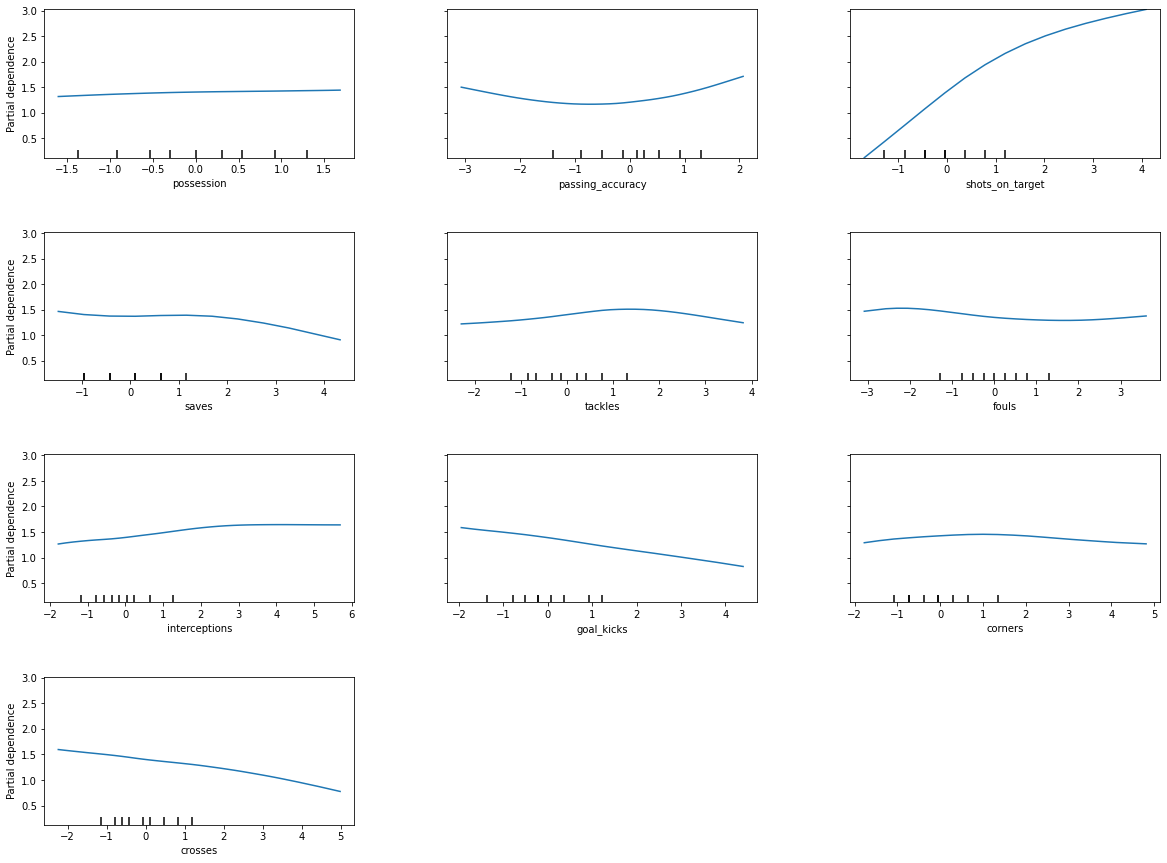

In [15]:
# Plot partial dependence plots (PDPs)

plot_partial_dependence(goalspred, features = featurelabels, X = train_features,
                        feature_names = featurelabels, grid_resolution = 50)

fig = plt.gcf()
fig.subplots_adjust(wspace=0.3, hspace=0.5)
fig.set_figheight(15)
fig.set_figwidth(20)

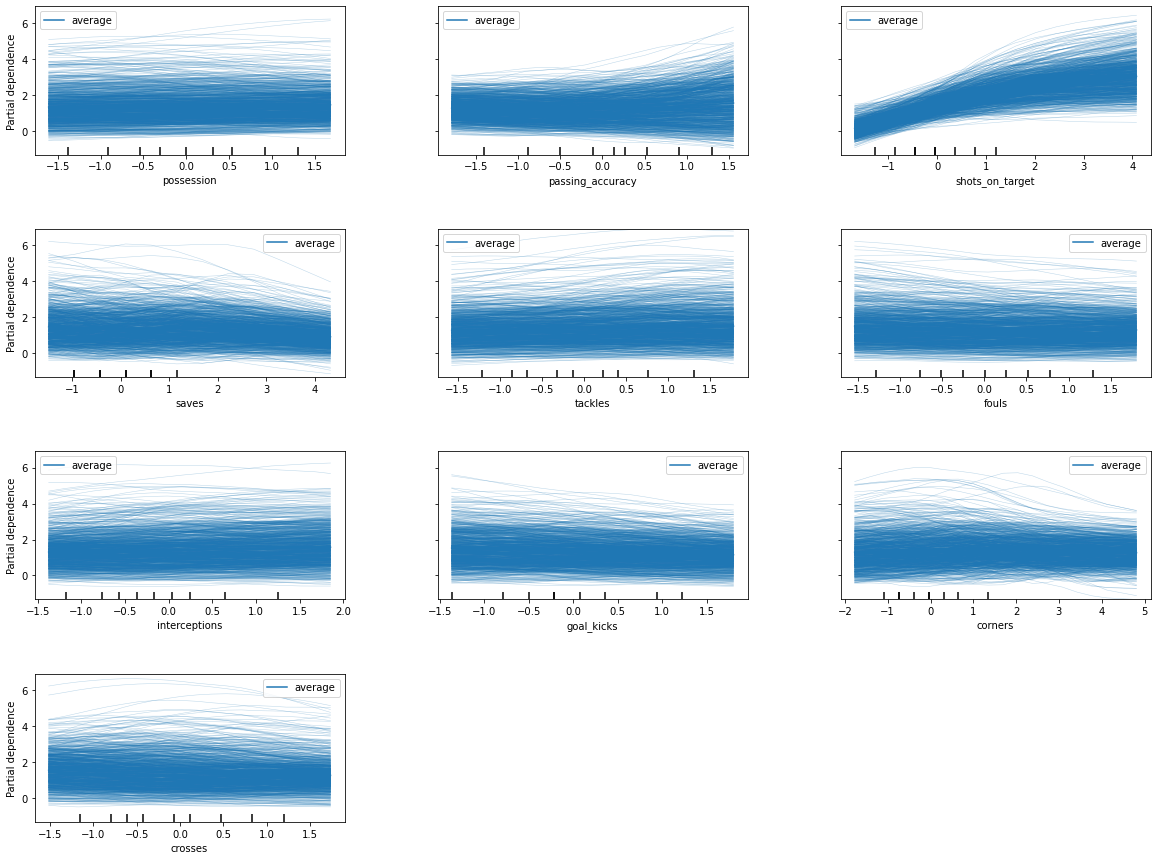

In [16]:
# Plot individual conditional expectations (ICEs)

plot_partial_dependence(goalspred, features = featurelabels, X = train_features, kind = "both", 
                        feature_names = featurelabels, grid_resolution = 20)

fig = plt.gcf()
fig.subplots_adjust(wspace=0.3, hspace=0.5)
fig.set_figheight(15)
fig.set_figwidth(20)

### SHAP Interpretation

In [17]:
# Normalize original data
scaler = StandardScaler().fit(features)
normfeatures = scaler.transform(features)
normfeatures = pd.DataFrame(normfeatures, columns = features.columns)

In [18]:
# Enables the display of SHAP plots
shap.initjs()

We write a function that takes in a sample index from 0 to 100. <br>
This function then uses 200 perterbation samples to estimate the SHAP values for the prediction of the value corresponding to the index.

In [19]:
def shap_predictone(index=0):
    if index < 0 or index >= 100:
        print("Index must be between 0 and 99, inclusive")
        return False
    
    # Takes the trained Keras model and explains why it makes different predictions for different matches
    # Here, we use a selection of the first 100 samples from the entire dataset to represent "typical" feature values
    explainer = shap.KernelExplainer(goalspred.predict, normfeatures.iloc[:100,:])
    
    shap_values = explainer.shap_values(normfeatures.iloc[index,:], nsamples=200)
    return shap.force_plot(explainer.expected_value, shap_values[0], normfeatures.iloc[index,:])

In [20]:
shap_predictone(99)

Alternatively, we can bunch up a number of samples and interpret them collectively with kernelSHAP.

In [21]:
explainer = shap.KernelExplainer(goalspred.predict, normfeatures.iloc[:100,:])
shap_values100 = explainer.shap_values(normfeatures.iloc[100:200,:], nsamples=200)
shap.force_plot(explainer.expected_value, shap_values100[0], normfeatures.iloc[100:200,:])

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

## Predictor model

In [23]:
posn = float(input("Enter possession, as a decimal percentage (from 0 to 1): "))
pasy = float(input("Enter passing accuracy, as a decimal percentage (from 0 to 1): "))
shot = int(input("Enter shots on target, as an integer: "))
savs = int(input("Enter saves, as an integer: "))
tacs = int(input("Enter tackles, as an integer: "))
fous = int(input("Enter fouls, as an integer: "))
ints = int(input("Enter interceptions, as an integer: "))
goas = int(input("Enter goal kicks, as an integer: "))
cors = int(input("Enter corners, as an integer: "))
cros = int(input("Enter crosses, as an integer: "))

meanarray = scaler.mean_
stdarray = np.sqrt(scaler.var_)

inputarray = [[posn, pasy, shot, savs, tacs, fous, ints, goas, cors, cros]]
calcarray = (inputarray - meanarray)/stdarray
prediction = goalspred.predict(calcarray)

print("Goals predicted is ", prediction[0][0])

Enter possession, as a decimal percentage (from 0 to 1):  .5
Enter passing accuracy, as a decimal percentage (from 0 to 1):  .5
Enter shots on target, as an integer:  6
Enter saves, as an integer:  7
Enter tackles, as an integer:  9
Enter fouls, as an integer:  4
Enter interceptions, as an integer:  16
Enter goal kicks, as an integer:  9
Enter corners, as an integer:  4
Enter crosses, as an integer:  7


Exception ignored in: <function tqdm.__del__ at 0x000002552E574280>
Traceback (most recent call last):
  File "C:\Users\zackr\anaconda3\envs\pic16b\lib\site-packages\tqdm\std.py", line 1145, in __del__
    self.close()
  File "C:\Users\zackr\anaconda3\envs\pic16b\lib\site-packages\tqdm\notebook.py", line 283, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'


Goals predicted is  1.9330554


In [ ]:
# Export the model and statistics for later use
goalspred.save('goalspred.h5')

statarray = np.array([meanarray, stdarray])
statframe = pd.DataFrame(statarray, columns = features.columns)
statframe.to_csv("goalspredstats.csv", index=False)